In [36]:
import numpy as np
import pandas as pd
import sklearn.compose as Compose

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb

Descargamos las datasets 

In [37]:
train_url = "https://raw.githubusercontent.com/w-dan/ML-practica1/main/train.csv"
df_train = pd.read_csv(train_url)

test_url = "https://raw.githubusercontent.com/w-dan/ML-practica1/main/test.csv"
df_test = pd.read_csv(test_url)

#df_test.Memory.unique()                       # Con esto vemos todos los valores posibles que tiene una columna

## Pre-procesamiento de datos de df_train

Vamos a guardar Price en la variable "y" y la vamos a separar del resto de columnas. 
También vamos a eliminar la columna "LaptopId" porque no nos aporta nada. 

In [38]:
index = df_train['LaptopId']
df_train = df_train.drop('LaptopId', axis=1)       # Borramos la ID porque no aporta nada

df_train    

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Toshiba,Portege Z30-C-1CV,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 7,1.2kg,1195.00
1,HP,Spectre 13-V111dx,Ultrabook,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.11kg,1349.00
2,Dell,Inspiron 5570,Notebook,15.6,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,128GB SSD + 1TB HDD,Intel UHD Graphics 620,Windows 10,2.02kg,855.00
3,HP,Envy 13-ad009n,Ultrabook,13.3,IPS Panel Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,256GB SSD,Nvidia GeForce MX150,Windows 10,1.38kg,1119.00
4,Dell,Latitude 7280,Ultrabook,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics,Windows 10,1.36kg,1472.20
...,...,...,...,...,...,...,...,...,...,...,...,...
907,Dell,Inspiron 5378,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.68kg,889.00
908,Asus,FX753VD-GC007T (i7-7700HQ/8GB/1TB,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1050,Windows 10,3kg,1168.00
909,Dell,Inspiron 5567,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16GB,2TB HDD,AMD Radeon R7 M445,Windows 10,2.32kg,989.99
910,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,AMD Radeon R5 M430,Linux,2.2kg,599.90


Como existen varios portátiles que disponen de dos tipos de memoria vamos a separar la columna "Memory" para distinguir entre estos tipos y su capacidad.
Lo distinguiremos en Memory1 y Memory2, cada una de ellas estará separada en su capacidad ("MemoryX_storage) y tipo ("MemoryX_type")

La tercera columna no nos aporta nada así que la borramos

###Tratamiento "Memory"

In [39]:
for index, row in df_train.iterrows():
   df_train.loc[index, 'Memory'].replace('Storage', '')

memory = df_train["Memory"].str.split(expand = True)
memory.columns = ['Memory1_storage', 'Memory1_type','borrar' ,'Memory2_storage', 'Memory2_type']

memory =  memory.drop('borrar', axis=1)       # borramos la tercera columna que no nos aporta nada.
memory

,Memory1_storage,Memory1_type,Memory2_storage,Memory2_type
0,128GB,SSD,None,None
1,256GB,SSD,None,None
2,128GB,SSD,1TB,HDD
3,256GB,SSD,None,None
4,256GB,SSD,None,None
...,...,...,...,...
907,256GB,SSD,None,None
908,128GB,SSD,1TB,HDD
909,2TB,HDD,None,None
910,1TB,HDD,None,None


Ahora vamos a eliminar la columna de "Memory" original que ya teníamos y vamos
a concatenar la nueva tabla con la anterior

Ahora vamos a convertir los TB a GB, para ello tenemos que recorrer las filas y sustituir los valores. Como el compilador no nos deja recorrer los datos si tenemos valores "None" vamos a convertirlo temporalmente a String para poder hacer esto.

Después de convertir los distintos datos a GB, vamos a covertir los valores "None", ya sean String o None, a un 0.

Ahora ya tendremos todos los datos de capacidad den Gigabytes

In [40]:
# Modificamos la antigua columna de Memory por las que hemos creado

df_train = df_train.drop('Memory', axis=1) 
df_train = pd.concat([df_train, memory], axis = 1)

# Convertimos todos los None en ceros

df_train['Memory2_storage'].replace(to_replace = [None], value = "None", inplace = True)
df_train['Memory1_storage'].replace(to_replace = [None], value = "None", inplace = True)

# Convertimos TB a GB

for index, row in df_train.iterrows():
   if 'TB' in row['Memory2_storage']:
     gb = int(df_train.loc[index, 'Memory2_storage'][0])*1024 
     df_train.loc[index, 'Memory2_storage'] = f"{gb}GB"


for index, row in df_train.iterrows():
   if 'TB' in row['Memory1_storage']:
     gb = int(df_train.loc[index, 'Memory1_storage'][0])*1024
     df_train.loc[index, 'Memory1_storage'] = f"{gb}GB"


df_train['Memory2_storage'].replace(to_replace = ["None"], value = 0, inplace = True)
df_train['Memory1_storage'].replace(to_replace = ["None"], value = 0, inplace = True)
df_train['Memory2_type'].replace(to_replace = [None], value = "0", inplace = True)                  # El 0 lo pongo como String para que luego al convertir los datos lo haga bien
df_train['Memory1_type'].replace(to_replace = [None], value = "0", inplace = True)


df_train

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Gpu,OpSys,Weight,Price,Memory1_storage,Memory1_type,Memory2_storage,Memory2_type
0,Toshiba,Portege Z30-C-1CV,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,Intel HD Graphics 520,Windows 7,1.2kg,1195.00,128GB,SSD,0,0
1,HP,Spectre 13-V111dx,Ultrabook,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,Intel HD Graphics 620,Windows 10,1.11kg,1349.00,256GB,SSD,0,0
2,Dell,Inspiron 5570,Notebook,15.6,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,Intel UHD Graphics 620,Windows 10,2.02kg,855.00,128GB,SSD,1024GB,HDD
3,HP,Envy 13-ad009n,Ultrabook,13.3,IPS Panel Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,Nvidia GeForce MX150,Windows 10,1.38kg,1119.00,256GB,SSD,0,0
4,Dell,Latitude 7280,Ultrabook,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,Intel HD Graphics,Windows 10,1.36kg,1472.20,256GB,SSD,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,Dell,Inspiron 5378,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,Intel HD Graphics 620,Windows 10,1.68kg,889.00,256GB,SSD,0,0
908,Asus,FX753VD-GC007T (i7-7700HQ/8GB/1TB,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,Nvidia GeForce GTX 1050,Windows 10,3kg,1168.00,128GB,SSD,1024GB,HDD
909,Dell,Inspiron 5567,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16GB,AMD Radeon R7 M445,Windows 10,2.32kg,989.99,2048GB,HDD,0,0
910,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,AMD Radeon R5 M430,Linux,2.2kg,599.90,1024GB,HDD,0,0


Ahora vamos a hacer como con la RAM, eliminar la subcadena "GB" de los discos. Para ello usamos el mismo método de antes, pero surge un problema, en los portátiles que no tienen alguno de sus discos se nos borra el valor 0.

Esto tiene fácil solución, usamos una función para que nos sustituya los valores vacíos por 0.

###Normalizando

Vamos a convertir los valores de "Typename", "Company", "OpSys", etc... en números para que se pueda trabajar con ellos.

También vamos a eliminar "GB" de los elementos de la columna RAM y las memorias al igual que vamos a eliminar "kg" de la columna "Weight" para dejar sólo los números    

Con las memorias surge un problema, en los portátiles que no tienen alguno de sus discos se nos borra el valor 0.

Esto tiene fácil solución, usamos una función para que nos sustituya los valores vacíos por 0.

Normalizamos las columnas que tenemos

In [41]:
df_train['Ram'] = df_train['Ram'].map(lambda x: str(x)[:-2])                                # Eliminamos dos últimos caracteres del contenido de 'Ram'
df_train['Weight'] = df_train['Weight'].map(lambda x: str(x)[:-2])                          # Igual con 'Weight'
df_train['Memory1_storage'] = df_train['Memory1_storage'].map(lambda x: str(x)[:-2])       
df_train['Memory2_storage'] = df_train['Memory2_storage'].map(lambda x: str(x)[:-2])

df_train = df_train.replace(r'^\s*$', value = 0, regex=True)                                #Cambia los espacios vacios por 0   ^\s*$ es espacio vacío

# Transformamos los valores del tipo de memoria para que sean tratables

enc = OrdinalEncoder()
df_train[['Memory1_type', 'Memory2_type', 'TypeName', 'Company', 'OpSys', 'Product', 'ScreenResolution', 'Cpu', 'Gpu']] = enc.fit_transform(df_train[['Memory1_type', 'Memory2_type', 'TypeName', 'Company', 'OpSys', 'Product', 'ScreenResolution', 'Cpu', 'Gpu']])

# Normalizamos todos los valores númericos que tenemos de momento
df_train[['Company', 'TypeName', 'Inches', 'Ram', 'Memory1_storage', 'Memory1_type', 'Memory2_storage', 'Memory2_type', 'OpSys', 'Weight', 'Cpu', 'Gpu', 'ScreenResolution', 'Product']] = MinMaxScaler().fit_transform(df_train[['Company', 'TypeName', 'Inches', 'Ram', 'Memory1_storage', 'Memory1_type', 'Memory2_storage', 'Memory2_type', 'OpSys', 'Weight', 'Cpu', 'Gpu', 'ScreenResolution', 'Product']])

df_train

Tratamiento de la columna CPU

Primero separamos las cadenas de caracteteres

In [42]:
prueba = df_train['Cpu'].str.split()

A continuación vamos a guardar en un array la parte que queremos separar

In [43]:
Cpu_Company = [x[0] for x in prueba]
Cpu_Model = [" ".join(x[1:-2]) for x in prueba]
Cpu_Frecuency = [x[-1] for x in prueba]

Después añadimos al Dataset las nuevas columnas que hemos creado

In [44]:
df_train['Cpu_Company'] = pd.DataFrame(Cpu_Company)
df_train['Cpu_Model'] = pd.DataFrame(Cpu_Model)
df_train['Cpu_Frecuency(GHz)'] = pd.DataFrame(Cpu_Frecuency)

Por último eliminamos las unidades de la columna de Cpu_Frecuency

In [45]:
df_train['Cpu_Frecuency(GHz)'] = df_train['Cpu_Frecuency(GHz)'].map(lambda x: str(x)[:-3])
df_train = df_train.drop('Cpu', axis=1)

Ahora vamos a tratar la columna de ScreenResolution separando la resolución de la tecnología que usan. Para ello vamos a seguir el mismo procedimiento que seguimos con la columna CPU

In [46]:
prueba = df_train['ScreenResolution'].str.split()
screen_resolution = [x[-1:] for x in prueba]
screen_tecnology = [" ".join(x[0:-1]) for x in prueba]
df_train['Screen_Resolution'] = pd.DataFrame(screen_resolution)
df_train['Screen_Technology'] = pd.DataFrame(screen_tecnology)
df_train = df_train.drop('ScreenResolution', axis=1)

In [47]:
prueba = df_train['Gpu'].str.split()
Gpu_Company = [x[0] for x in prueba]
Gpu_Model = [" ".join(x[1:]) for x in prueba]
df_train['Gpu_Company'] = pd.DataFrame(Gpu_Company)
df_train['Gpu_Model'] = pd.DataFrame(Gpu_Model)
df_train = df_train.drop('Gpu', axis=1)
df_train

,Company,Product,TypeName,Inches,Ram,OpSys,Weight,Price,Memory1_storage,Memory1_type,Memory2_storage,Memory2_type,Cpu_Company,Cpu_Model,Cpu_Frecuency(GHz),Screen_Resolution,Screen_Technology,Gpu_Company,Gpu_Model
0,Toshiba,Portege Z30-C-1CV,Notebook,13.3,4,Windows 7,1.2,1195.00,128,SSD,0,0,Intel,Core i5,2.3,1920x1080,Full HD,Intel,HD Graphics 520
1,HP,Spectre 13-V111dx,Ultrabook,13.3,8,Windows 10,1.11,1349.00,256,SSD,0,0,Intel,Core i7,2.7,1920x1080,IPS Panel Full HD / Touchscreen,Intel,HD Graphics 620
2,Dell,Inspiron 5570,Notebook,15.6,8,Windows 10,2.02,855.00,128,SSD,1024,HDD,Intel,Core i7,1.8,1920x1080,Full HD,Intel,UHD Graphics 620
3,HP,Envy 13-ad009n,Ultrabook,13.3,8,Windows 10,1.38,1119.00,256,SSD,0,0,Intel,Core i7,2.7,1920x1080,IPS Panel Full HD,Nvidia,GeForce MX150
4,Dell,Latitude 7280,Ultrabook,12.5,8,Windows 10,1.36,1472.20,256,SSD,0,0,Intel,Core i5,2.5,1920x1080,Full HD / Touchscreen,Intel,HD Graphics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,Dell,Inspiron 5378,2 in 1 Convertible,13.3,8,Windows 10,1.68,889.00,256,SSD,0,0,Intel,Core i5,2.5,1920x1080,Full HD / Touchscreen,Intel,HD Graphics 620
908,Asus,FX753VD-GC007T (i7-7700HQ/8GB/1TB,Gaming,17.3,8,Windows 10,3,1168.00,128,SSD,1024,HDD,Intel,Core i7,2.8,1920x1080,Full HD,Nvidia,GeForce GTX 1050
909,Dell,Inspiron 5567,Notebook,15.6,16,Windows 10,2.32,989.99,2048,HDD,0,0,Intel,Core i7,2.7,1920x1080,Full HD,AMD,Radeon R7 M445
910,Dell,Inspiron 3567,Notebook,15.6,8,Linux,2.2,599.90,1024,HDD,0,0,Intel,Core i7,2.7,1920x1080,Full HD,AMD,Radeon R5 M430


In [48]:
df_train['Company'].unique()

array(['Toshiba', 'HP', 'Dell', 'Lenovo', 'Asus', 'Microsoft', 'Vero',
       'MSI', 'Acer', 'Apple', 'Mediacom', 'Samsung', 'Razer', 'Google',
       'Fujitsu', 'Chuwi', 'Huawei', 'LG', 'Xiaomi'], dtype=object)

Preprocesamiento

In [30]:
ordinal_encoder = Compose.ColumnTransformer(transformers=[
    ("Company", OrdinalEncoder(), [0]),
    ("Product", OrdinalEncoder(), [1]),
    ("TypeName", OrdinalEncoder(), [2]),
    ("Inches", "passthrough", [3]),
    ("Ram", "passthrough", [4]),
    ("OpSys", OrdinalEncoder(), [5]),
    ("Weight", "passthrough", [6]),
    ("Memory1_storage", "passthrough", [7]),
    ("Memory1_type", OrdinalEncoder(), [8]),
    ("Memory2_storage", "passthrough", [9]),
    ("Memory2_type", OrdinalEncoder(), [10]),
    ("Cpu_Company", OrdinalEncoder(), [11]),
    ("Cpu_Model", OrdinalEncoder(), [12]),
    ("Cpu_Frecuency", "passthrough", [13]),
    ("Screen_Resolution", OrdinalEncoder(), [14]),
    ("Screen_Technology", OrdinalEncoder(), [15]),
    ("Gpu_Company", OrdinalEncoder(), [16]),
    ("Gpu_Model", OrdinalEncoder(), [17])
])

min_max_esclaer = Compose.ColumnTransformer(transformers=[
    ("Company", MinMaxScaler(), [0]),
    #("Product", MinMaxScaler(), [1]),
    ("TypeName", MinMaxScaler(), [2]),
    ("Inches", MinMaxScaler(), [3]),
    ("Ram", MinMaxScaler(), [4]),
    ("OpSys", MinMaxScaler(), [5]),
    ("Weight", MinMaxScaler(), [6]),
    ("Memory1_storage", MinMaxScaler(), [7]),
    ("Memory1_type", MinMaxScaler(), [8]),
    ("Memory2_storage", MinMaxScaler(), [9]),
    ("Memory2_type", MinMaxScaler(), [10]),
    ("Cpu_Company", MinMaxScaler(), [11]),
    ("Cpu_Model", MinMaxScaler(), [12]),
    ("Cpu_Frecuency", MinMaxScaler(), [13]),
    ("Screen_Resolution", MinMaxScaler(), [14]),
    ("Screen_Technology", MinMaxScaler(), [15]),
    ("Gpu_Company", MinMaxScaler(), [16]),
    ("Gpu_Model", MinMaxScaler(), [17])
])

In [31]:
X = df_train[['Company', 'Product', 'TypeName', 'Inches', 'Ram', 'OpSys', 'Weight', 'Memory1_storage', 'Memory1_type', 'Memory2_storage', 'Memory2_type', 'Cpu_Company', 'Cpu_Model', 'Cpu_Frecuency(GHz)', 'Screen_Resolution', 'Screen_Technology','Gpu_Company', 'Gpu_Model']]
y = df_train['Price']

In [32]:
X = ordinal_encoder.fit_transform(X.to_numpy())
X

array([[16.0, 262.0, 3.0, ..., 3.0, 2.0, 41.0],
       [7.0, 326.0, 4.0, ..., 9.0, 2.0, 46.0],
       [4.0, 191.0, 3.0, ..., 3.0, 2.0, 89.0],
       ...,
       [4.0, 189.0, 3.0, ..., 3.0, 0.0, 81.0],
       [4.0, 183.0, 3.0, ..., 3.0, 0.0, 77.0],
       [10.0, 376.0, 3.0, ..., 8.0, 3.0, 8.0]], dtype=object)

In [33]:
X = min_max_esclaer.fit_transform(X)
X

array([[0.88888889, 0.6       , 0.44444444, ..., 0.15      , 0.66666667,
        0.46067416],
       [0.38888889, 0.8       , 0.44444444, ..., 0.45      , 0.66666667,
        0.51685393],
       [0.22222222, 0.6       , 0.76388889, ..., 0.15      , 0.66666667,
        1.        ],
       ...,
       [0.22222222, 0.6       , 0.76388889, ..., 0.15      , 0.        ,
        0.91011236],
       [0.22222222, 0.6       , 0.76388889, ..., 0.15      , 0.        ,
        0.86516854],
       [0.55555556, 0.6       , 0.54166667, ..., 0.4       , 1.        ,
        0.08988764]])

## Pre-procesamiento de datos de df_test

In [ ]:
df_test = df_test.drop('LaptopId', axis=1)       # Borramos la ID porque no aporta nada

df_test

###Tratamiento "Memory"

Como existen varios portátiles que disponen de dos tipos de memoria vamos a separar la columna "Memory" para distinguir entre estos tipos y su capacidad. Lo distinguiremos en Memory1 y Memory2, cada una de ellas estará separada en su capacidad ("MemoryX_storage) y tipo ("MemoryX_type")

La tercera columna no nos aporta nada así que la borramos

In [ ]:
for index, row in df_test.iterrows():
  df_test.loc[index, 'Memory'] = df_test.loc[index, 'Memory'].replace("Storage", "")

memoryt = df_test["Memory"].str.split(expand = True)
memoryt.columns = ['Memory1_storage', 'Memory1_type','borrar' ,'Memory2_storage', 'Memory2_type']

memoryt =  memoryt.drop('borrar', axis=1)       # borramos la tercera columna que no nos aporta nada.
memoryt

Ahora vamos a convertir los TB a GB, para ello tenemos que recorrer las filas y sustituir los valores. Como el compilador no nos deja recorrer los datos si tenemos valores "None" vamos a convertirlo temporalmente a String para poder hacer esto.

Después de convertir los distintos datos a GB, vamos a covertir los valores "None", ya sean String o None, a un 0.

Ahora ya tendremos todos los datos de capacidad den Gigabytes

In [ ]:
# Sustituimos la antigua columna de Memory por las creadas anteriormente

df_test = df_test.drop('Memory', axis=1) 
df_test = pd.concat([df_test, memoryt], axis = 1)
df_test

# Convertimos todos los None en ceros

df_test['Memory2_storage'].replace(to_replace = [None], value = "None", inplace = True)
df_test['Memory1_storage'].replace(to_replace = [None], value = "None", inplace = True)

# Convertimos de TB a GB

for index, row in df_test.iterrows():
   if 'TB' in row['Memory2_storage']:
     gb = int(df_test.loc[index, 'Memory2_storage'][0])*1024 
     df_test.loc[index, 'Memory2_storage'] = f"{gb}GB"


for index, row in df_test.iterrows():
   if 'TB' in row['Memory1_storage']:
     gb = int(df_test.loc[index, 'Memory1_storage'][0])*1024
     df_test.loc[index, 'Memory1_storage'] = f"{gb}GB"


df_test['Memory2_storage'].replace(to_replace = ["None"], value = 0, inplace = True)
df_test['Memory1_storage'].replace(to_replace = ["None"], value = 0, inplace = True)
df_test['Memory2_type'].replace(to_replace = [None], value = "0", inplace = True)                  # El 0 lo pongo como String para que luego al convertir los datos lo haga bien
df_test['Memory1_type'].replace(to_replace = [None], value = "0", inplace = True)

df_test

Ahora vamos a hacer como con la RAM, eliminar la subcadena "GB" de los discos. Para ello usamos el mismo método de antes, pero 

###Normalizando

Vamos a convertir los valores de "Typename", "Company", "OpSys", etc... en números para que se pueda trabajar con ellos.

También vamos a eliminar "GB" de los elementos de la columna RAM y las memorias al igual que vamos a eliminar "kg" de la columna "Weight" para dejar sólo los números    

Con las memorias surge un problema, en los portátiles que no tienen alguno de sus discos se nos borra el valor 0.

Esto tiene fácil solución, usamos una función para que nos sustituya los valores vacíos por 0.

Normalizamos las columnas que tenemos

In [ ]:
df_test['Ram'] = df_test['Ram'].map(lambda x: str(x)[:-2])                     # Eliminamos dos últimos caracteres del contenido de 'Ram'
df_test['Weight'] = df_test['Weight'].map(lambda x: str(x)[:-2])               # Igual con 'Weight'
df_test['Memory1_storage'] = df_test['Memory1_storage'].map(lambda x: str(x)[:-2])
df_test['Memory2_storage'] = df_test['Memory2_storage'].map(lambda x: str(x)[:-2])

df_test = df_test.replace(r'^\s*$', value = 0, regex=True)                       #Cambia los espacios vacios por 0   ^\s*$ es espacio vacío

# Transformamos los valores del tipo de memoria para que sean tratables
df_test[['TypeName', 'Company', 'OpSys', 'Product', 'ScreenResolution', 'Cpu', 'Gpu', 'Memory1_type', 'Memory2_type']] = enc.fit_transform(df_test[['TypeName', 'Company', 'OpSys', 'Product', 'ScreenResolution', 'Cpu', 'Gpu','Memory1_type', 'Memory2_type']])

# Normalizamos todos los valores númericos que tenemos de momento
df_test[['Company', 'TypeName', 'Inches', 'Ram', 'Memory1_storage', 'Memory1_type', 'Memory2_storage', 'Memory2_type', 'OpSys', 'Weight', 'Cpu', 'Gpu', 'ScreenResolution', 'Product']] = MinMaxScaler().fit_transform(df_test[['Company', 'TypeName', 'Inches', 'Ram', 'Memory1_storage', 'Memory1_type', 'Memory2_storage', 'Memory2_type', 'OpSys', 'Weight', 'Cpu', 'Gpu', 'ScreenResolution', 'Product']])

df_test

##XGBOOST

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

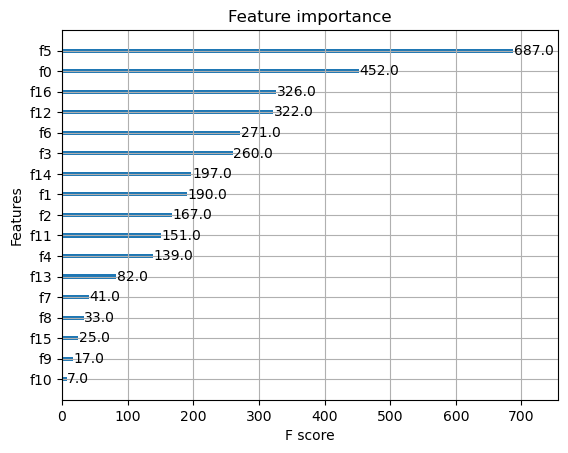

In [34]:
#X_train = df_train[['Ram', 'Memory1_storage', 'Memory1_type', 'Memory2_storage', 'Memory2_type', 'Cpu', 'Gpu', 'ScreenResolution', 'Company', 'OpSys', 'Weight', 'Product', 'Inches', 'TypeName']]
#X_test = df_test[['Ram', 'Memory1_storage', 'Memory1_type', 'Memory2_storage', 'Memory2_type', 'Cpu', 'Gpu', 'ScreenResolution', 'Company', 'OpSys', 'Weight', 'Product', 'Inches', 'TypeName']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = XGBRegressor()

# Fitting the model
model.fit(X_train, y_train)

# Pintamos la importancia de cada una de las columnas

%matplotlib inline
xgb.plot_importance(model, ax=plt.gca())

In [35]:
predTrain = model.predict(X_train)        # Predicción del Train
pred = model.predict(X_test)              # Predicción del Test

print("MAE (train): ", mean_absolute_error(y_train, predTrain))
print("MAE (test): ", mean_absolute_error(y_test, pred))

MAE (train):  21.543744981341227
MAE (test):  197.61036925155753


In [ ]:
pred

##Otras cosas:

### Dudas:

- ¿Se puede usar XGBoost para esta práctica?

### Cosas que hacer (Cynthia):

- Hacer lo de las Seed y eso para XGBoost


### Bibliografía

Sitios de los que he sacado infomación y otros que pueden venir bien luego



split:

https://www.analyticslane.com/2020/10/19/separar-texto-en-columnas-con-pandas-en-python/


iterar elementos del Dataframe:

https://www.analyticslane.com/2021/09/13/pandas-como-iterar-sobre-las-filas-de-un-dataframe-en-pandas/


pandas:

https://guias.makeitreal.camp/pandas/inspeccion-y-seleccion-de-datos


eliminar duplicados (Aquí no hay):

https://cursosinformatica.ucm.es/trial/analisis/